#**Feed Forward Neural Network Implementation**

###In this project I would lead you through implementation of Feedforward Neural Network for solving one of the most known regression projects, Californa housing.

###Feedforward Neural Network

A feedforward neural network (FNN) is one of the two broad types of artificial neural network, characterized by direction of the flow of information between its layers. Its flow is uni-directional, meaning that the information in the model flows in only one direction—forward—from the input nodes, through the hidden nodes and to the output nodes, without any cycles or loops. Modern feedforward networks are trained using the backpropagation method and are colloquially referred to as the "vanilla" neural networks.

Activation function used in this project, [`rectified linear unit (ReLU) function`](https://en.wikipedia.org/wiki/Ramp_function) (also known as the `ramp or hinge function`) $f: \mathbb{R} \mapsto [0,\infty)$ is a piecewise linear function defined as:

\begin{align}
f(x) := \max (0,x) = x\mathbf{1}_{\{x>0\}} = \begin{cases}
           x, & \text{if $x>0$}\\
           0, & \text{otherwise}.
	   \end{cases}
\end{align}

The first-order derivative is zero for $x < 0$, one for $x>0$, and it is not defined for $x=0$.

The standard ReLU function is a kink-shaped function which is constructed by mixing the identity and the binary step function. It is one of the most commonly used activation functions for hidden layers due to the following characteristics:
* `Simplicity and easy implementation` since it is piecewise linear function,
* `Representational sparcity` (i.e., the property of giving zero as the output) which improves the computational speed,
* `Improved convergence` over other popular activation function such as the sigmoid and hyperbolic tangent functions (e.g., the vanishing gradient problem).

For optimizer purposes, I've used **kerras optimizer** with **Adam** and **Stohastic Gradient Descent** (SGD) as optimization function.

In later part of the project, hyperparameters optimization will focus on two parameters,

*   epochs
*   batch_size


Epochs will take values from 50 to 500 with values [50, 100, 250,500].

Batch_size will take values from 32 to 256 with progressive step of power of 2.


##**Project**

####Install all needed packages

In [ ]:
pip install scikeras

In [ ]:
pip install tensorflow

####Import all needed packages

In [ ]:
#Basic
import numpy as np
from numpy import (where, unique)
import pandas as pd
from pandas import set_option
import datetime as dt
import statsmodels.api as sm

#Data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#NN
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam

#Plot
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
import seaborn as sns

####Import in-sample and out-of-sample performance results with supervised learning models from for the same regression problem

In [ ]:
supervised_results = pd.read_csv('out.csv',index_col=0)
supervised_results

,OLS,PLS6,PLS7,PLS,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV
Train R2,0.627655,0.613700,0.623862,0.627655,0.627655,0.627655,0.405098,0.627638,0.281270,0.627605
Test R2,0.608066,0.590902,0.603757,0.608066,0.608063,0.608063,0.388042,0.608066,0.270475,0.608008
Train MSE,0.372812,0.386784,0.376610,0.372812,0.372812,0.372812,0.595648,0.372829,0.719632,0.372862
Test MSE,0.389943,0.407019,0.394229,0.389943,0.389945,0.389945,0.608848,0.389943,0.725818,0.390000
Train MAE,0.479471,0.483717,0.481748,0.479471,0.479468,0.479468,0.625327,0.479480,0.703016,0.479464
Test MAE,0.489302,0.494770,0.492617,0.489302,0.489299,0.489299,0.629463,0.489300,0.703858,0.489274


####Import California housing dataset

In [ ]:
california_housing = fetch_california_housing()
print(california_housing.DESCR)
df_california_housing = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df_california_housing['MedHouseVal'] = california_housing.target
df_california_housing['MedHouseVal'] = df_california_housing['MedHouseVal'].astype(float)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

####Preview the data and the information about variables

In [ ]:
df_california_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df_california_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


**There is no NaN values in this dataset.**

####Outliers checking

In [ ]:
df_california_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


We see that AveOccup and Popluation have outliers in the upper bounds, and AveRooms, AveBedrms have outliers on both sides. MedInc probably too. Next we will visualy check outliers.

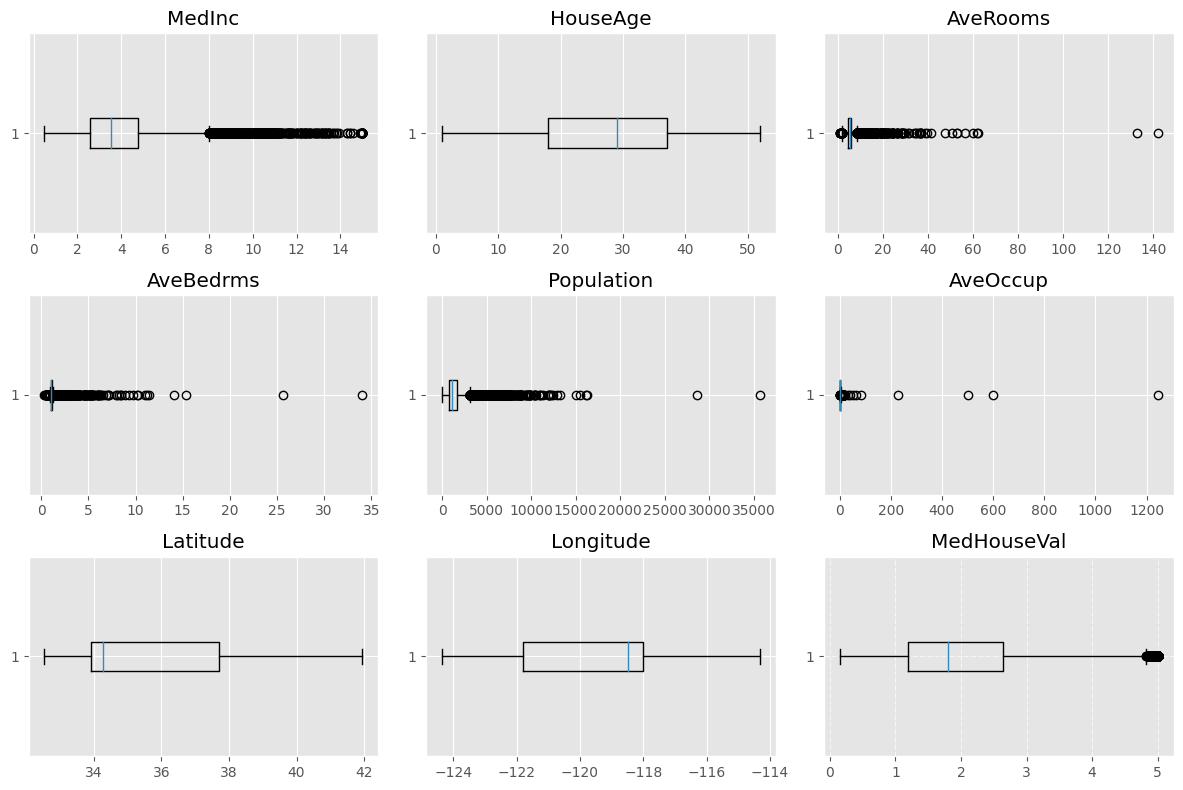

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

axes = axes.flatten()

for i, column in enumerate(df_california_housing.columns):
    ax = axes[i]
    ax.boxplot(df_california_housing[column], vert=False)
    ax.set_title(column)

for i in range(len(df_california_housing.columns), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.grid(color='white', linestyle='-.', linewidth=0.5)
plt.show()

**Per conclustions of this research paper [The Effects of Outliers Data on Neural Network Performance
](https://scialert.net/fulltext/?doi=jas.2005.1394.1398) I've have decided to remove outliers for variables that have them**

Removal of outliers from the data. One percent from both lower and upper bound.

In [ ]:
df_california_housing_outlierd = df_california_housing.copy()

#Calculate Percentiles
lower_percentiles = df_california_housing.quantile(0.01)
upper_percentiles = df_california_housing.quantile(0.99)

#Clip Values
clip_returns = df_california_housing_outlierd.clip(lower=lower_percentiles, upper=upper_percentiles, axis=1)

#Update the DataFrame
df_california_housing_outlierd.loc[:,'AveRooms'] = clip_returns['AveRooms']
df_california_housing_outlierd.loc[:,'AveBedrms'] = clip_returns['AveBedrms']
df_california_housing_outlierd.loc[:,'Population'] = clip_returns['Population']
df_california_housing_outlierd.loc[:,'AveOccup'] = clip_returns['AveOccup']
df_california_housing_outlierd.loc[:,'MedInc'] = clip_returns['MedInc']

df_california_housing_outlierd.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Checking of data after outlier removal

In [ ]:
df_california_housing_outlierd.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.852240,28.639486,5.334186,1.077081,1404.011958,2.916367,35.631861,-119.569704,2.068558
std,1.803929,12.585558,1.321643,0.158544,972.927381,0.732299,2.135952,2.003532,1.153956
min,1.069631,1.000000,2.581133,0.872840,88.000000,1.536686,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,10.596540,52.000000,10.357033,2.127541,5805.830000,5.394812,41.950000,-114.310000,5.000010


Visual checking of variables after outliers removal.

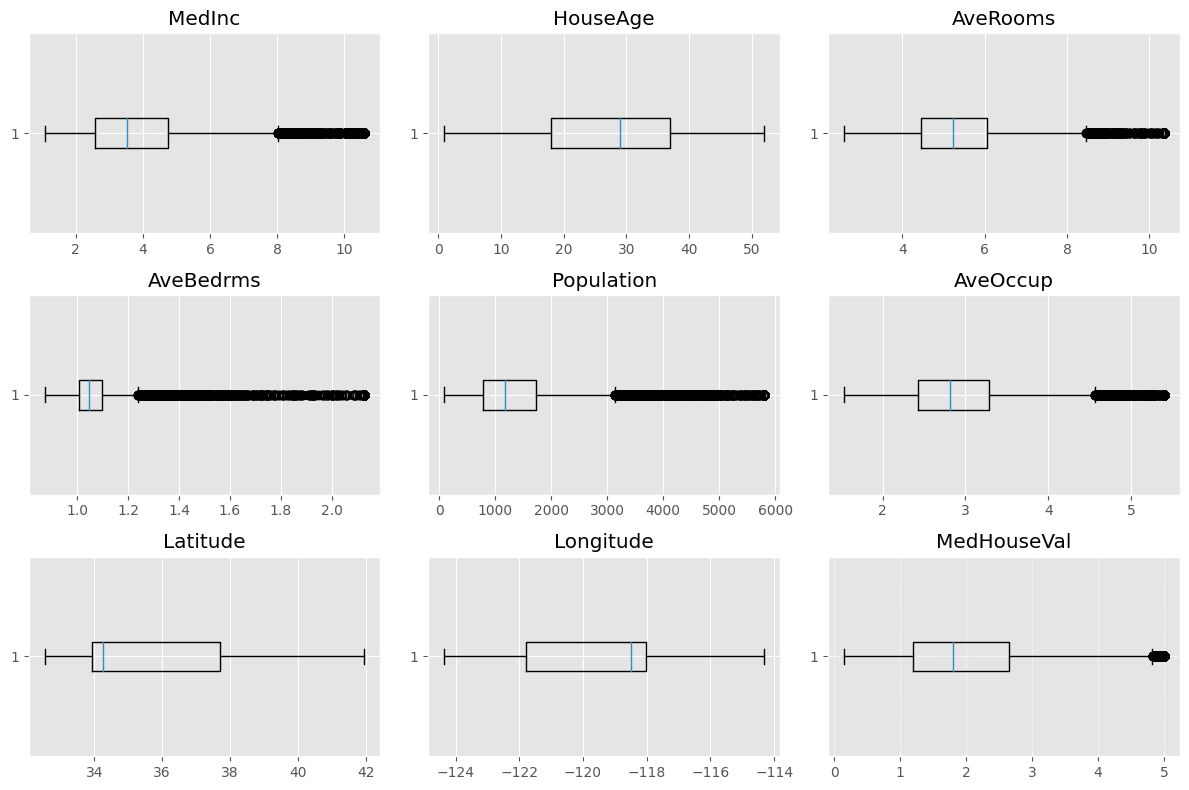

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

axes = axes.flatten()

for i, column in enumerate(df_california_housing_outlierd.columns):
    ax = axes[i]
    ax.boxplot(df_california_housing_outlierd[column], vert=False)
    ax.set_title(column)

for i in range(len(df_california_housing_outlierd.columns), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.grid(color='white', linestyle='-.', linewidth=0.5)
plt.show()

Finished dealing with outliers

####Correlation Matrix

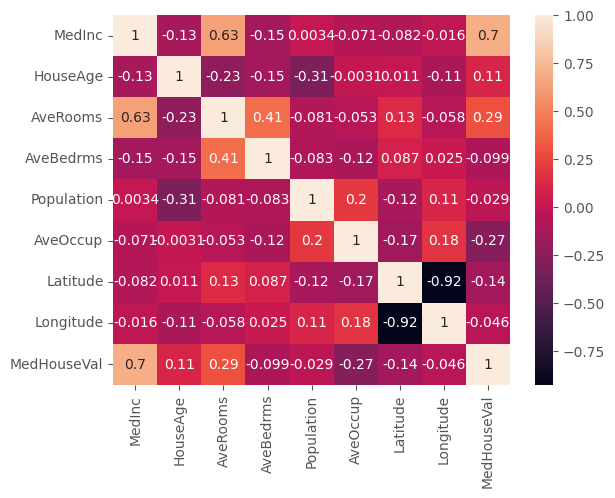

In [ ]:
corr_matrix = df_california_housing_outlierd.corr()
sns.heatmap(corr_matrix,annot=True)
plt.show()

####Standardization of data

In [ ]:
df_california_housing_final = (df_california_housing_outlierd - df_california_housing_outlierd.mean()) / (df_california_housing_outlierd.std())

In [ ]:
df_california_housing_final.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.479565,0.982119,1.248401,-0.336003,-1.112120,-0.492710,1.052523,-1.327803,2.129580
1,2.466371,-0.607004,0.683960,-0.663541,1.024730,-1.101360,1.043159,-1.322812,1.314124
2,1.887635,1.856137,2.235059,-0.022924,-0.933278,-0.155820,1.038478,-1.332794,1.258663
3,0.992755,1.856137,0.365579,-0.025365,-0.869553,-0.503102,1.038478,-1.337785,1.165072
4,-0.003348,1.856137,0.717037,0.025231,-0.862358,-1.003551,1.038478,-1.337785,1.172871


In [ ]:
train_data = df_california_housing_final[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']]
train_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.479565,0.982119,1.248401,-0.336003,-1.112120,-0.492710,1.052523,-1.327803
1,2.466371,-0.607004,0.683960,-0.663541,1.024730,-1.101360,1.043159,-1.322812
2,1.887635,1.856137,2.235059,-0.022924,-0.933278,-0.155820,1.038478,-1.332794
3,0.992755,1.856137,0.365579,-0.025365,-0.869553,-0.503102,1.038478,-1.337785
4,-0.003348,1.856137,0.717037,0.025231,-0.862358,-1.003551,1.038478,-1.337785
...,...,...,...,...,...,...,...,...
20635,-1.270527,-0.289180,-0.218464,0.354807,-0.574567,-0.485813,1.801603,-0.758808
20636,-0.718121,-0.845373,0.590060,1.505631,-1.077174,0.281907,1.806285,-0.818702
20637,-1.193085,-0.924829,-0.097336,0.271291,-0.408059,-0.806681,1.778194,-0.823693
20638,-1.100398,-0.845373,-0.003536,0.598187,-0.681461,-1.083106,1.778194,-0.873605


In [ ]:
test_data = df_california_housing_final[['MedHouseVal']]
test_data

,MedHouseVal
0,2.129580
1,1.314124
2,1.258663
3,1.165072
4,1.172871
...,...
20635,-1.115777
20636,-1.124443
20637,-0.992722
20638,-1.058583


####Data spliting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, test_data, test_size=0.2, random_state=42)

###**Implementation of FFNN model**

Implementation of three layer FFNN model.

In [ ]:
ffnn_model = Sequential(name='FFNN_Model')
ffnn_model.add(Dense(8,
                     activation='relu',
                     input_dim=X_train.shape[1],
                     name='Hidden_Layer_1'
                    )
              )
ffnn_model.add(Dense(4,
                     activation='relu',
                     name='Hidden_Layer_2'
                    )
              )
ffnn_model.add(Dense(2,
                     activation='relu',
                     name='Hidden_Layer_3'
                    )
              )
ffnn_model.add(Dense(1,
                     activation='linear',
                     name='Output_Layer'
                    )
              )

####Model compilation with SGD optimizer

In [ ]:
ffnn_model.compile(
    optimizer='sgd',
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.R2Score(),
             tf.keras.metrics.MeanSquaredError(),
             tf.keras.metrics.MeanAbsoluteError()]
)

Fitting the model

In [ ]:
n_epochs     = 500
n_batch_size = 128

ffnn_model_ccd = ffnn_model.fit(X_train,
                                y_train,
                                epochs=n_epochs,
                                batch_size=n_batch_size,
                                validation_data=(X_test, y_test)
                               )

In [ ]:
print(ffnn_model_ccd.history.keys())

dict_keys(['loss', 'r2_score', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_r2_score', 'val_mean_squared_error', 'val_mean_absolute_error'])


SGD optimizer R2 Score

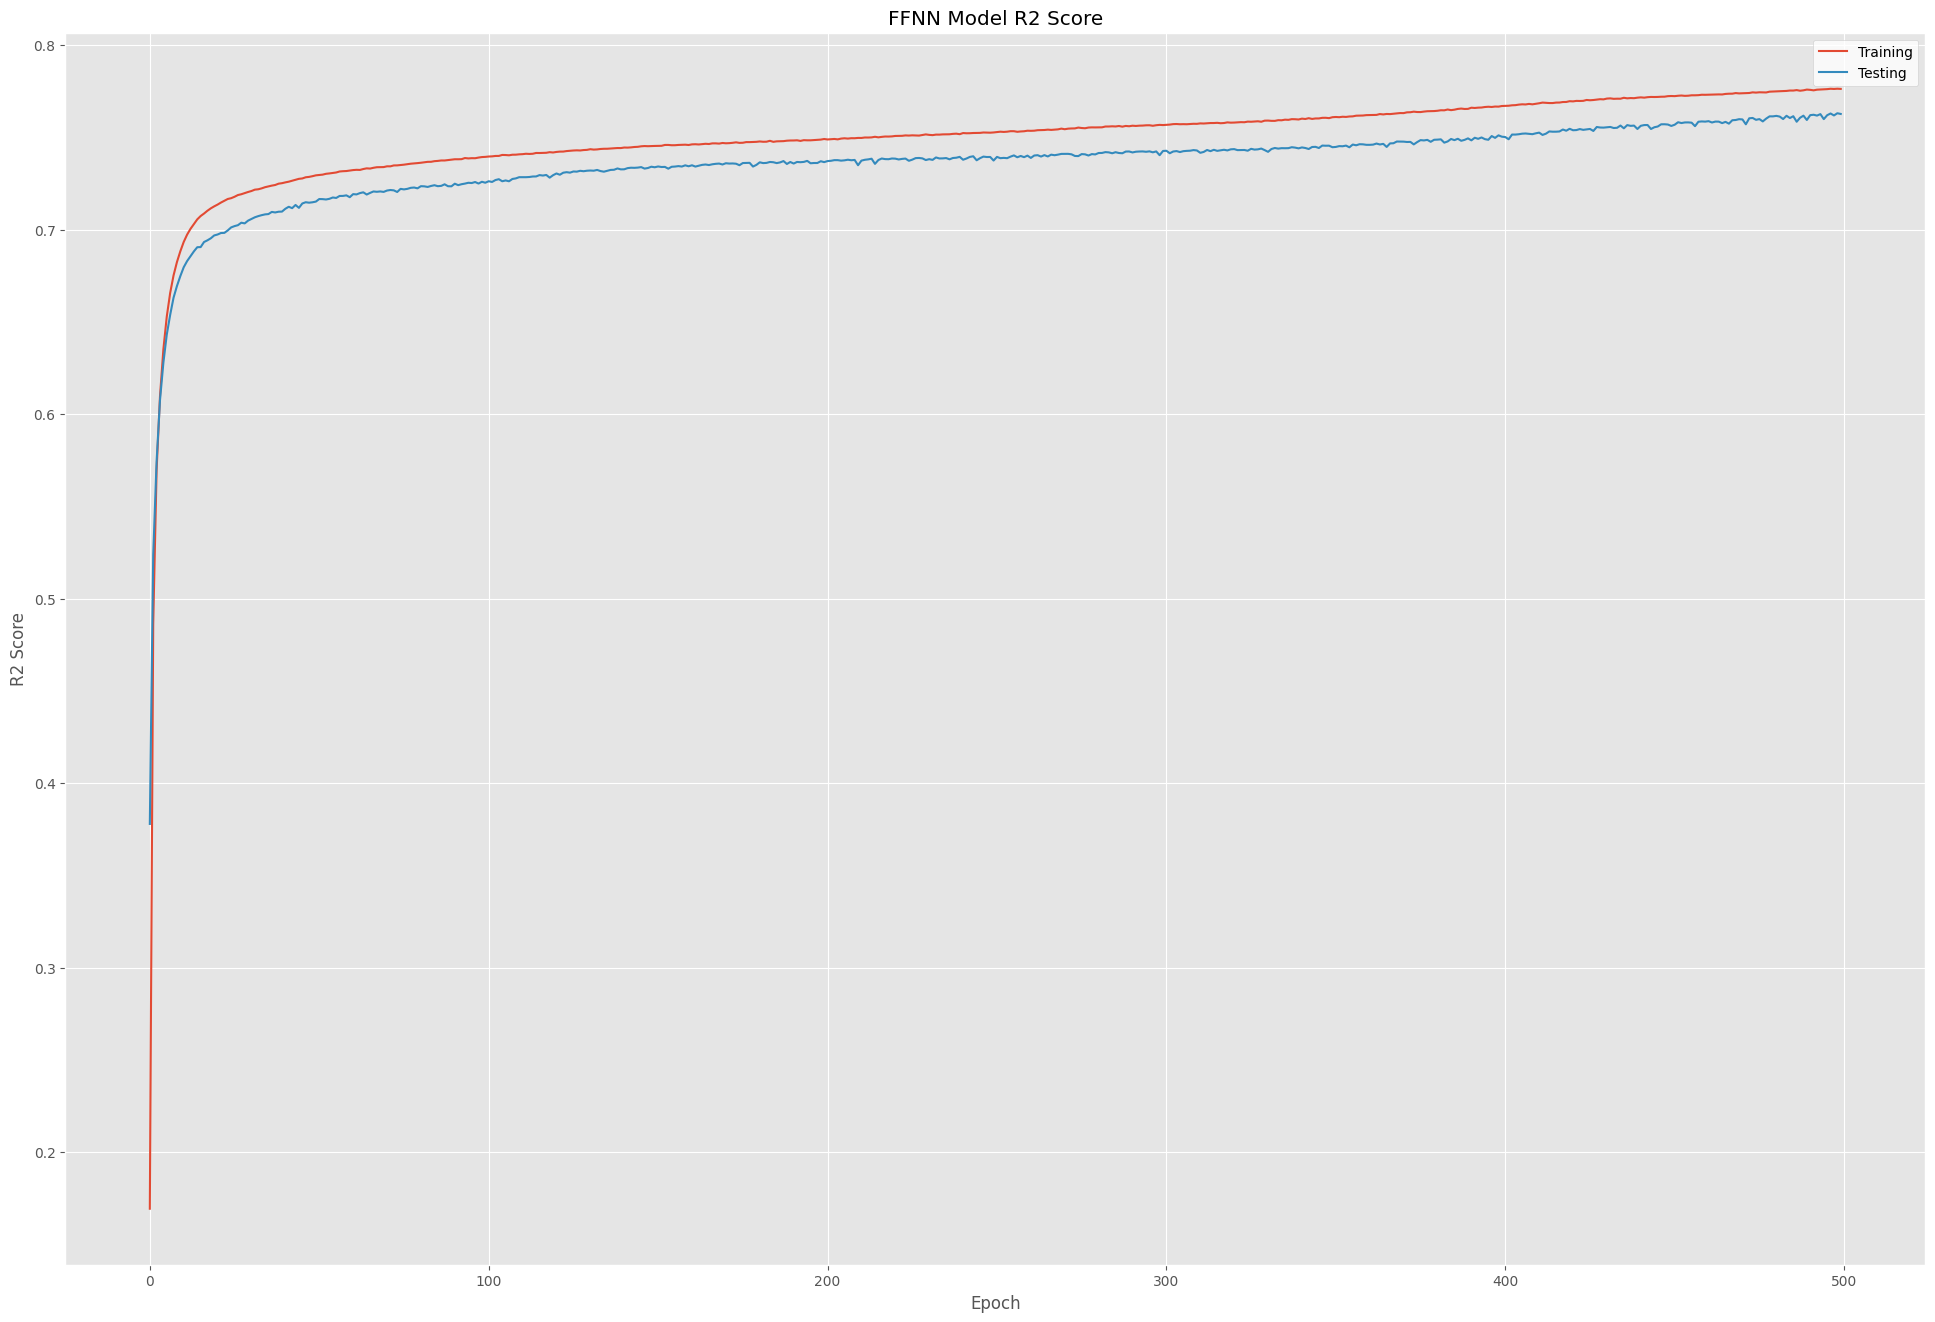

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_ccd.history['r2_score'])
plt.plot(ffnn_model_ccd.history['val_r2_score'])
plt.title('FFNN Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

SGD Optimizer Loss Function

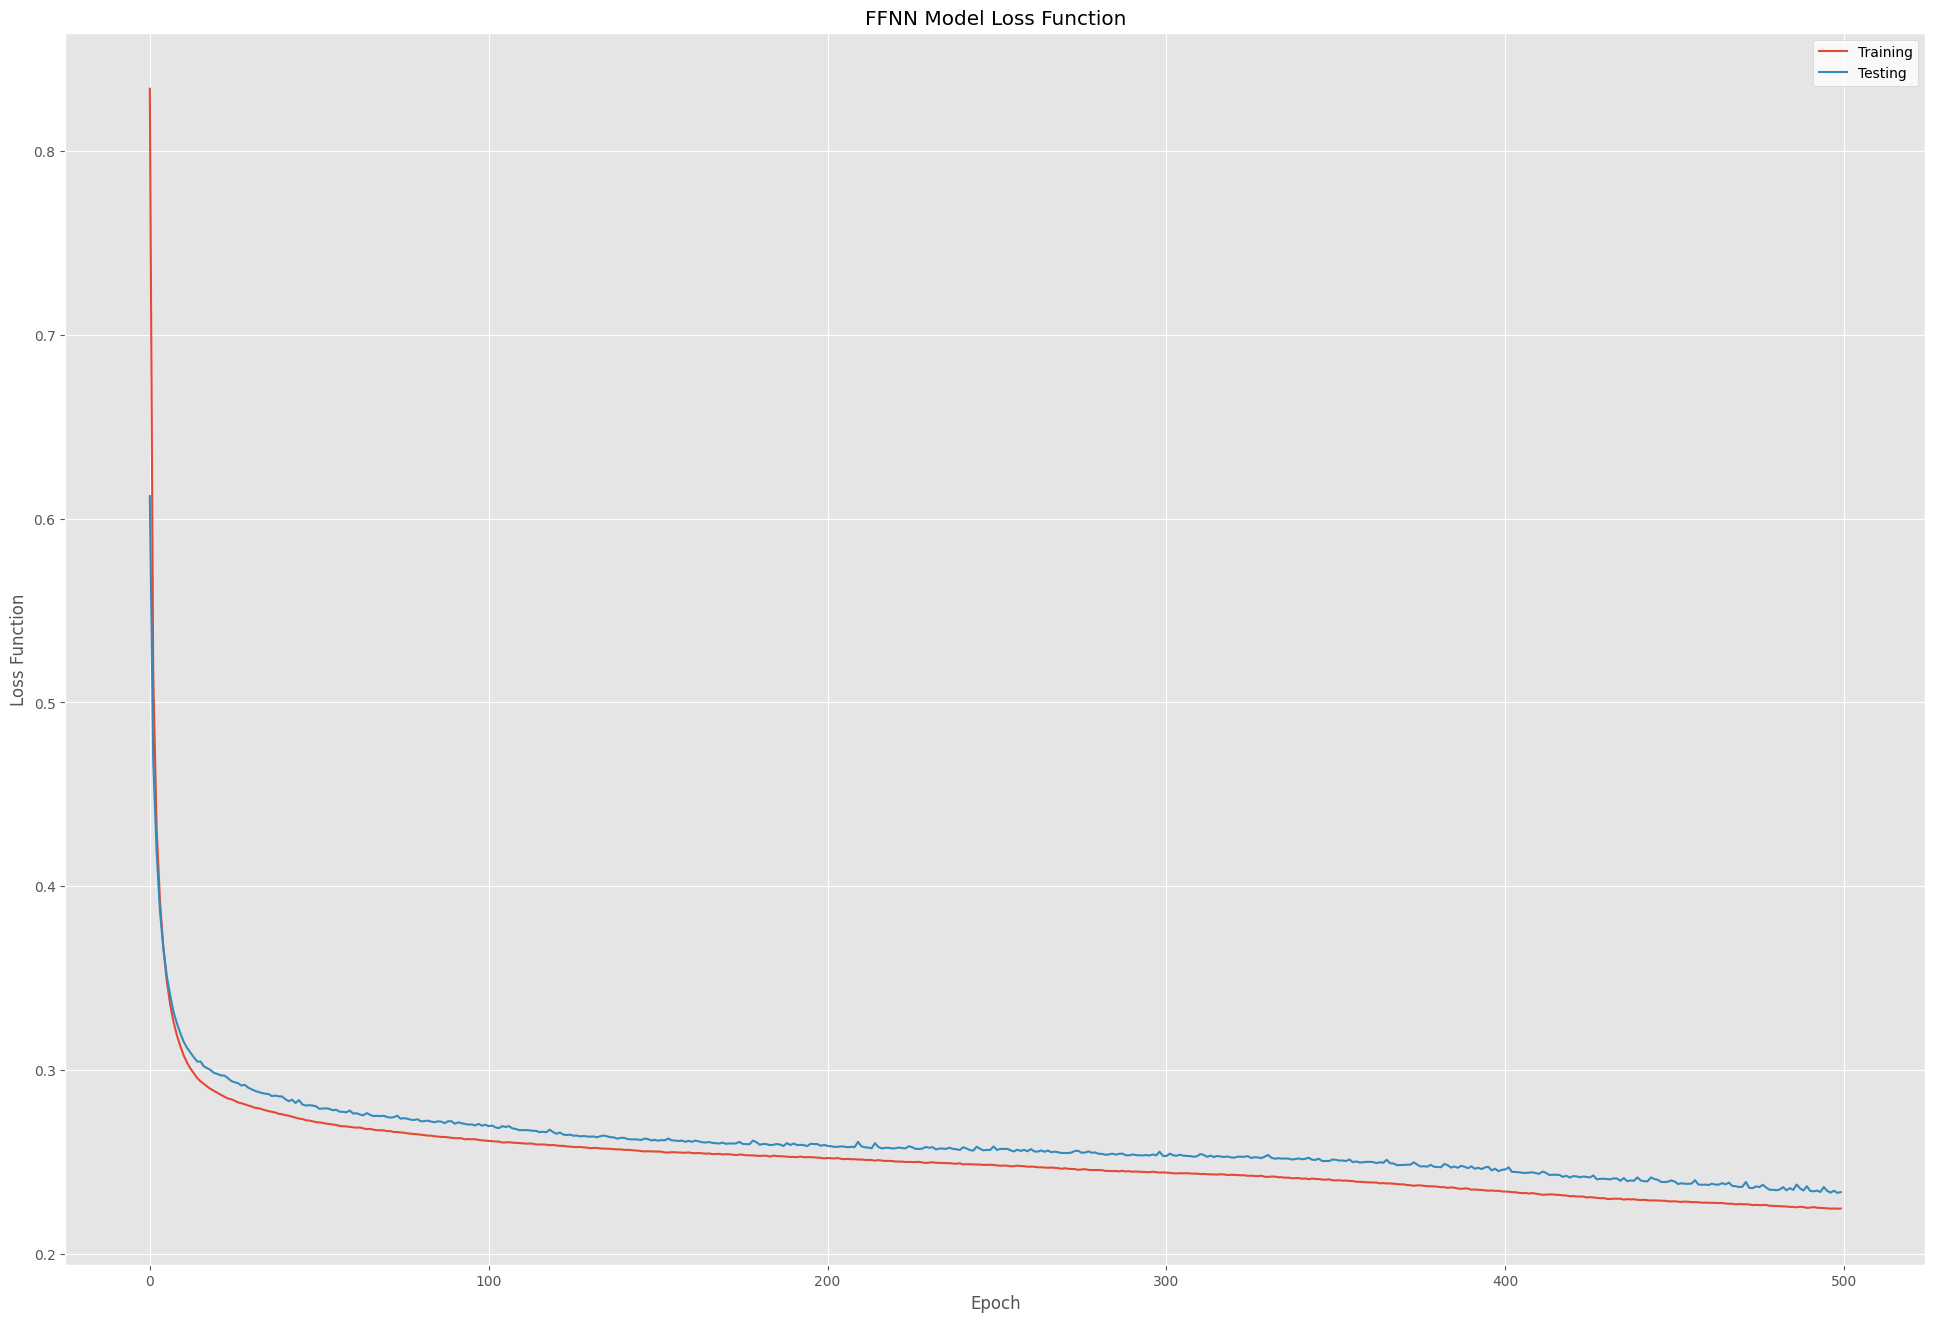

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_ccd.history['loss'])
plt.plot(ffnn_model_ccd.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

Final metrics for model with SGD as optimizer

In [ ]:
metrics_sgd_train = ffnn_model.evaluate(X_train, y_train)


516/516 [==============================] - 1s 1ms/step - loss: 0.2233 - r2_score: 0.7775 - mean_squared_error: 0.2233 - mean_absolute_error: 0.3249


In [ ]:
metrics_sgd_test = ffnn_model.evaluate(X_test, y_test)


129/129 [==============================] - 0s 1ms/step - loss: 0.2335 - r2_score: 0.7627 - mean_squared_error: 0.2335 - mean_absolute_error: 0.3292


####Model with Adam as optimizer, and learning rate as parameter.

In [ ]:
ffnn_model_adam = Sequential(name='FFNN_Model')
ffnn_model_adam.add(Dense(8,
                     activation='relu',
                     input_dim=X_train.shape[1],
                     name='Hidden_Layer_1'
                    )
              )
ffnn_model_adam.add(Dense(4,
                     activation='relu',
                     name='Hidden_Layer_2'
                    )
              )
ffnn_model_adam.add(Dense(2,
                     activation='relu',
                     name='Hidden_Layer_3'
                    )
              )
ffnn_model_adam.add(Dense(1,
                     activation='linear',
                     name='Output_Layer'
                    )
              )

In [ ]:
ffnn_model_adam.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.R2Score(),
             tf.keras.metrics.MeanSquaredError(),
             tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
n_epochs     = 500
n_batch_size = 128

ffnn_model_adam_ccd = ffnn_model_adam.fit(X_train,
                                y_train,
                                epochs=n_epochs,
                                batch_size=n_batch_size,
                                validation_data=(X_test, y_test)
                               )

Epoch 1/500
129/129 [==============================] - 1s 3ms/step - loss: 1.0169 - r2_score: -0.0129 - mean_squared_error: 1.0169 - mean_absolute_error: 0.8018 - val_loss: 0.7991 - val_r2_score: 0.1879 - val_mean_squared_error: 0.7991 - val_mean_absolute_error: 0.7206
Epoch 2/500
129/129 [==============================] - 0s 2ms/step - loss: 0.6143 - r2_score: 0.3881 - mean_squared_error: 0.6143 - mean_absolute_error: 0.6310 - val_loss: 0.4908 - val_r2_score: 0.5012 - val_mean_squared_error: 0.4908 - val_mean_absolute_error: 0.5633
Epoch 3/500
129/129 [==============================] - 0s 2ms/step - loss: 0.4266 - r2_score: 0.5750 - mean_squared_error: 0.4266 - mean_absolute_error: 0.5171 - val_loss: 0.3989 - val_r2_score: 0.5946 - val_mean_squared_error: 0.3989 - val_mean_absolute_error: 0.4953
Epoch 4/500
129/129 [==============================] - 0s 2ms/step - loss: 0.3693 - r2_score: 0.6321 - mean_squared_error: 0.3693 - mean_absolute_error: 0.4730 - val_loss: 0.3642 - val_r2_scor

Adam optimizer R2 score

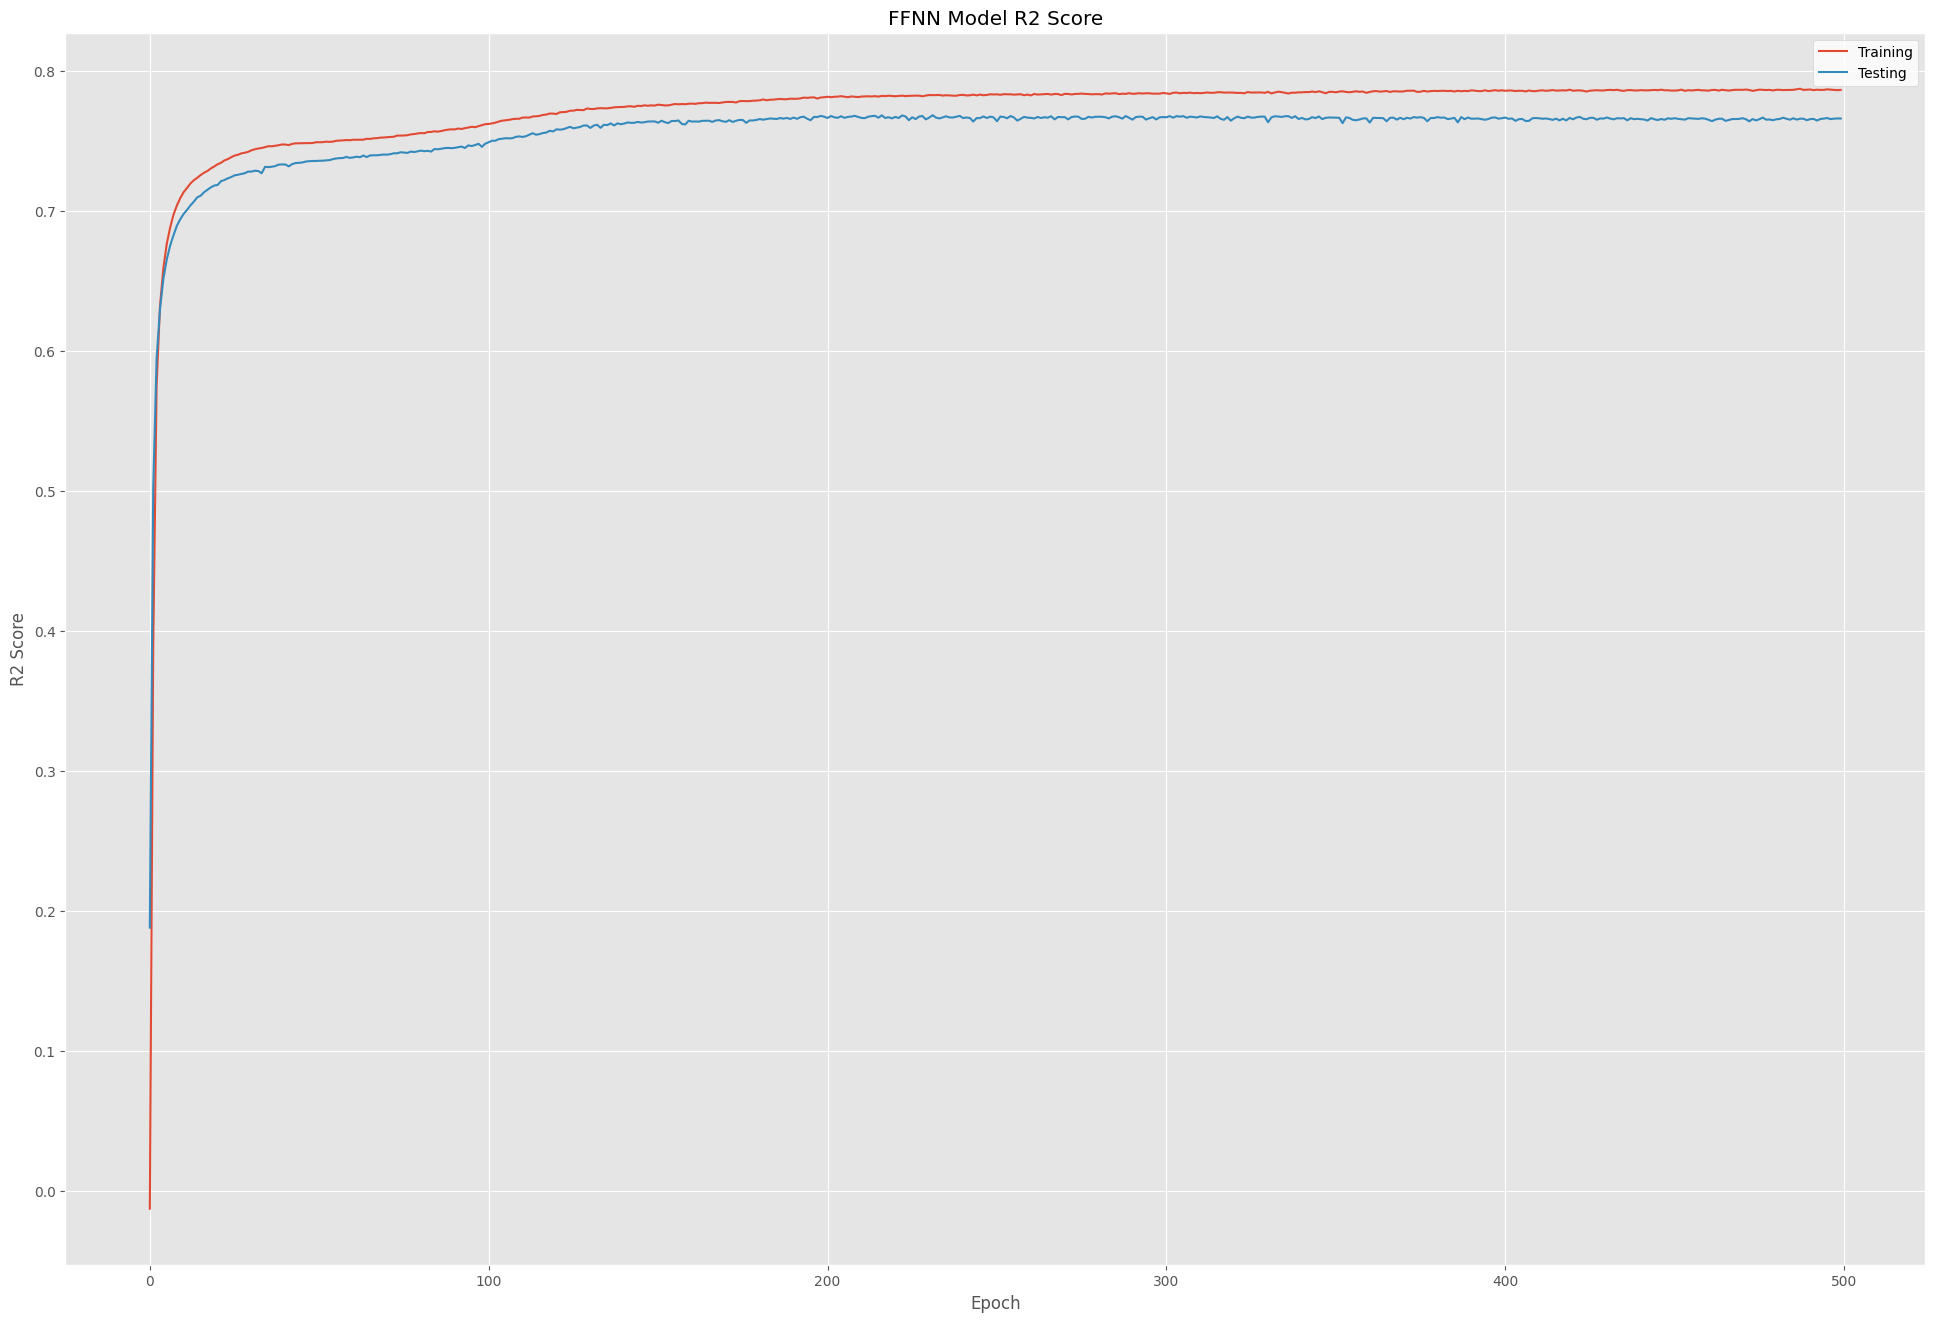

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_adam_ccd.history['r2_score'])
plt.plot(ffnn_model_adam_ccd.history['val_r2_score'])
plt.title('FFNN Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

Adam optmizer Loss function

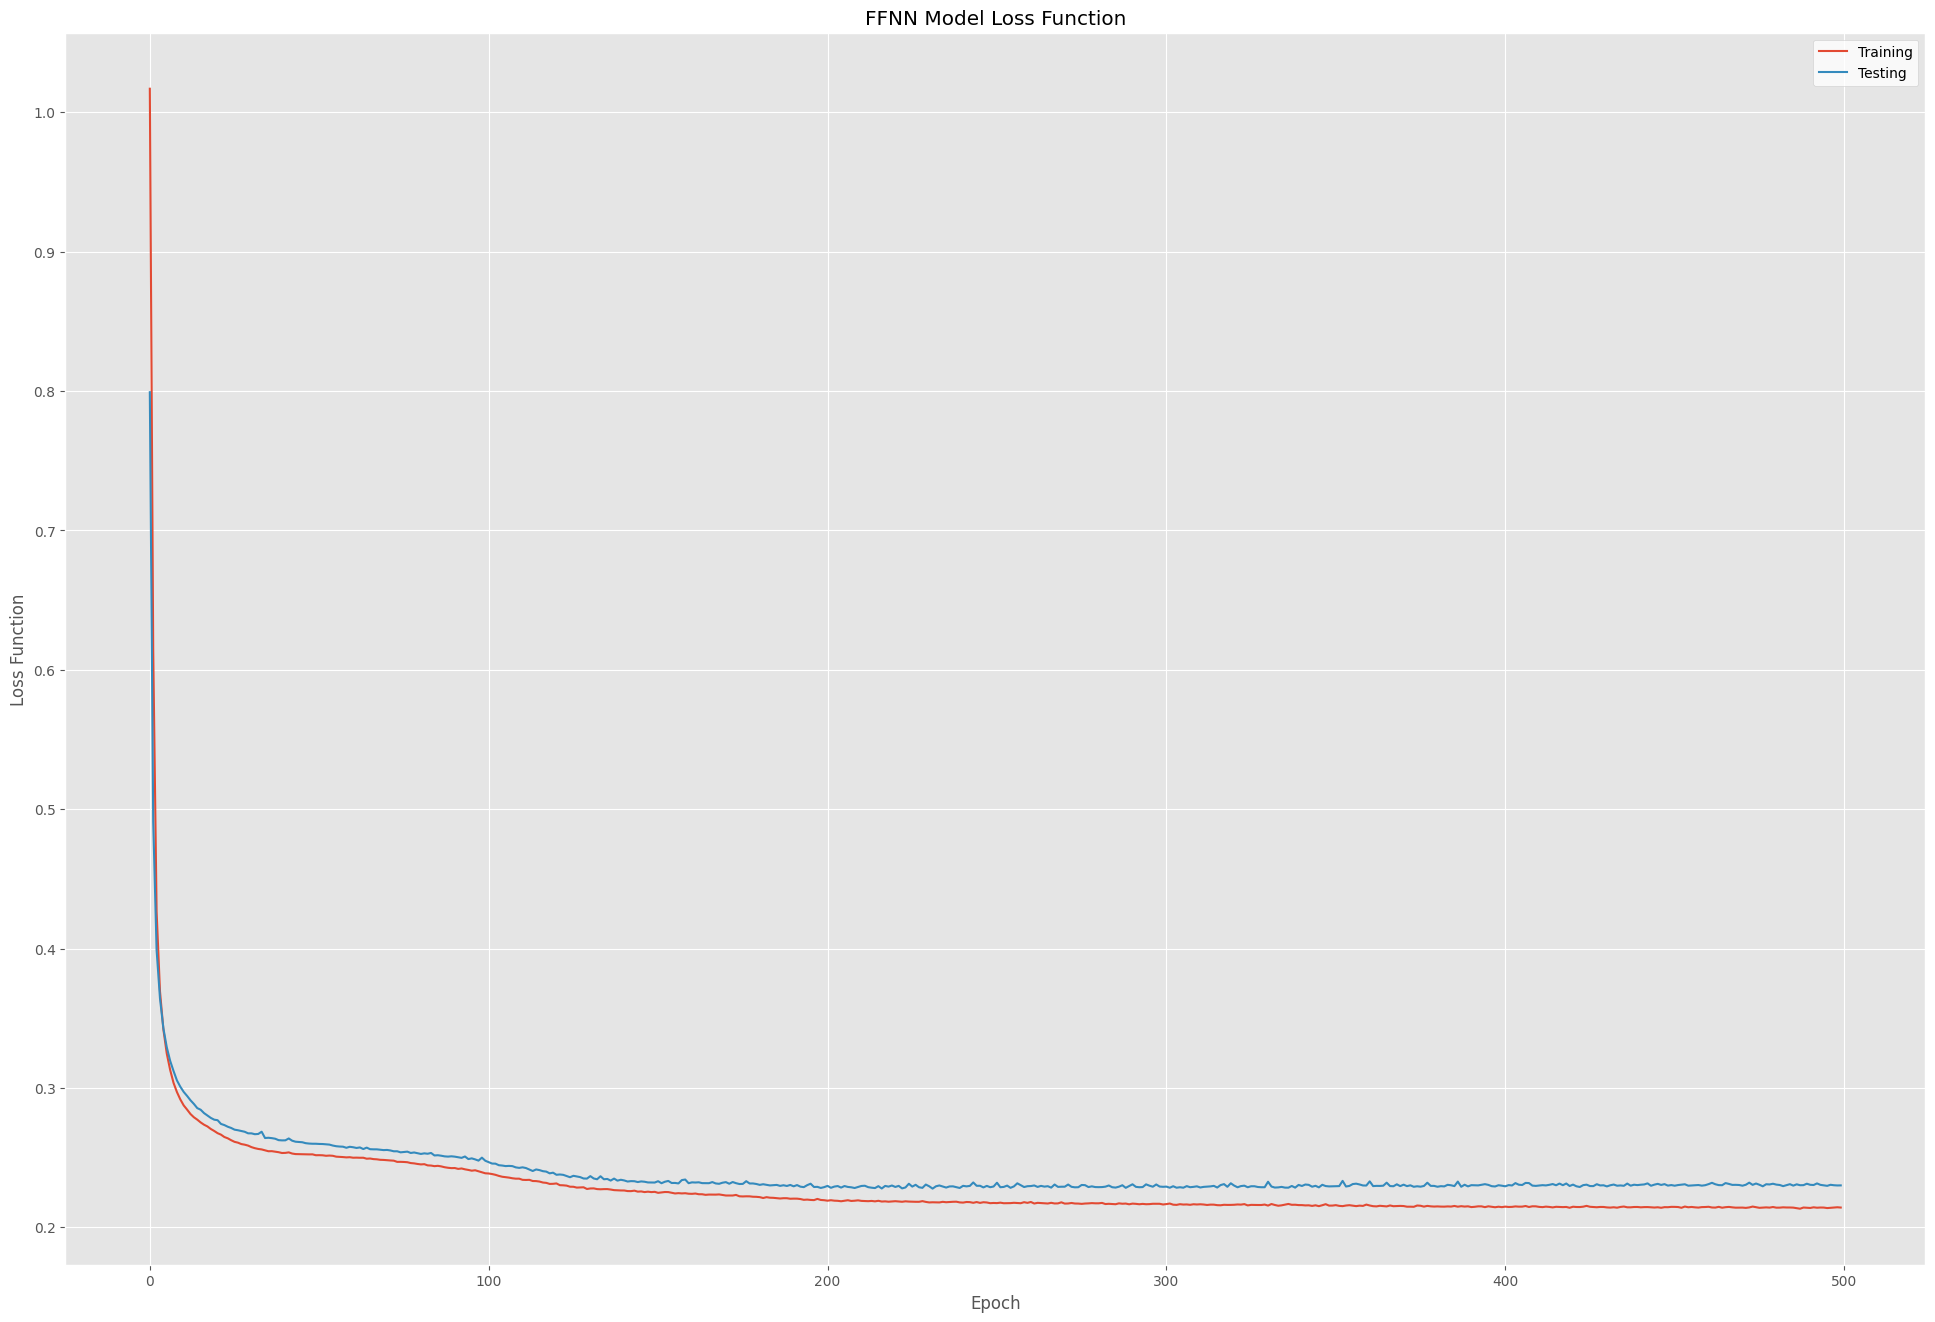

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_adam_ccd.history['loss'])
plt.plot(ffnn_model_adam_ccd.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [ ]:
metrics_adam_train = ffnn_model_adam.evaluate(X_train, y_train)

516/516 [==============================] - 1s 1ms/step - loss: 0.2122 - r2_score: 0.7886 - mean_squared_error: 0.2122 - mean_absolute_error: 0.3164


In [ ]:
metrics_adam_test = ffnn_model_adam.evaluate(X_test, y_test)

129/129 [==============================] - 0s 1ms/step - loss: 0.2301 - r2_score: 0.7662 - mean_squared_error: 0.2301 - mean_absolute_error: 0.3261


##Comparison of FFNN models with supervised models

In [ ]:
metrics_adam_final = [metrics_adam_train[1],metrics_adam_test[1],metrics_adam_train[2],metrics_adam_test[2],metrics_adam_train[3], metrics_adam_test[3]]
metrics_sgd_final = [metrics_sgd_train[1],metrics_sgd_test[1],metrics_sgd_train[2],metrics_sgd_test[2],metrics_sgd_train[3], metrics_sgd_test[3]]

In [ ]:
supervised_results['FFNN_adam'] = metrics_adam_final
supervised_results['FFNN_sgd'] = metrics_sgd_final
supervised_results

,OLS,PLS6,PLS7,PLS,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV,FFNN_adam,FFNN_sgd
Train R2,0.627655,0.613700,0.623862,0.627655,0.627655,0.627655,0.405098,0.627638,0.281270,0.627605,0.788607,0.777524
Test R2,0.608066,0.590902,0.603757,0.608066,0.608063,0.608063,0.388042,0.608066,0.270475,0.608008,0.766167,0.762694
Train MSE,0.372812,0.386784,0.376610,0.372812,0.372812,0.372812,0.595648,0.372829,0.719632,0.372862,0.212213,0.223339
Test MSE,0.389943,0.407019,0.394229,0.389943,0.389945,0.389945,0.608848,0.389943,0.725818,0.390000,0.230109,0.233526
Train MAE,0.479471,0.483717,0.481748,0.479471,0.479468,0.479468,0.625327,0.479480,0.703016,0.479464,0.316429,0.324923
Test MAE,0.489302,0.494770,0.492617,0.489302,0.489299,0.489299,0.629463,0.489300,0.703858,0.489274,0.326092,0.329185


In [ ]:
supervised_results_transpose = supervised_results.T
supervised_results_transpose

,Train R2,Test R2,Train MSE,Test MSE,Train MAE,Test MAE
OLS,0.627655,0.608066,0.372812,0.389943,0.479471,0.489302
PLS6,0.613700,0.590902,0.386784,0.407019,0.483717,0.494770
PLS7,0.623862,0.603757,0.376610,0.394229,0.481748,0.492617
PLS,0.627655,0.608066,0.372812,0.389943,0.479471,0.489302
Ridge,0.627655,0.608063,0.372812,0.389945,0.479468,0.489299
RidgeCV,0.627655,0.608063,0.372812,0.389945,0.479468,0.489299
Lasso,0.405098,0.388042,0.595648,0.608848,0.625327,0.629463
LassoCV,0.627638,0.608066,0.372829,0.389943,0.479480,0.489300
ElasticNet,0.281270,0.270475,0.719632,0.725818,0.703016,0.703858
ElasticNetCV,0.627605,0.608008,0.372862,0.390000,0.479464,0.489274


###Plot metrics for each of models created in HW2 and HW4

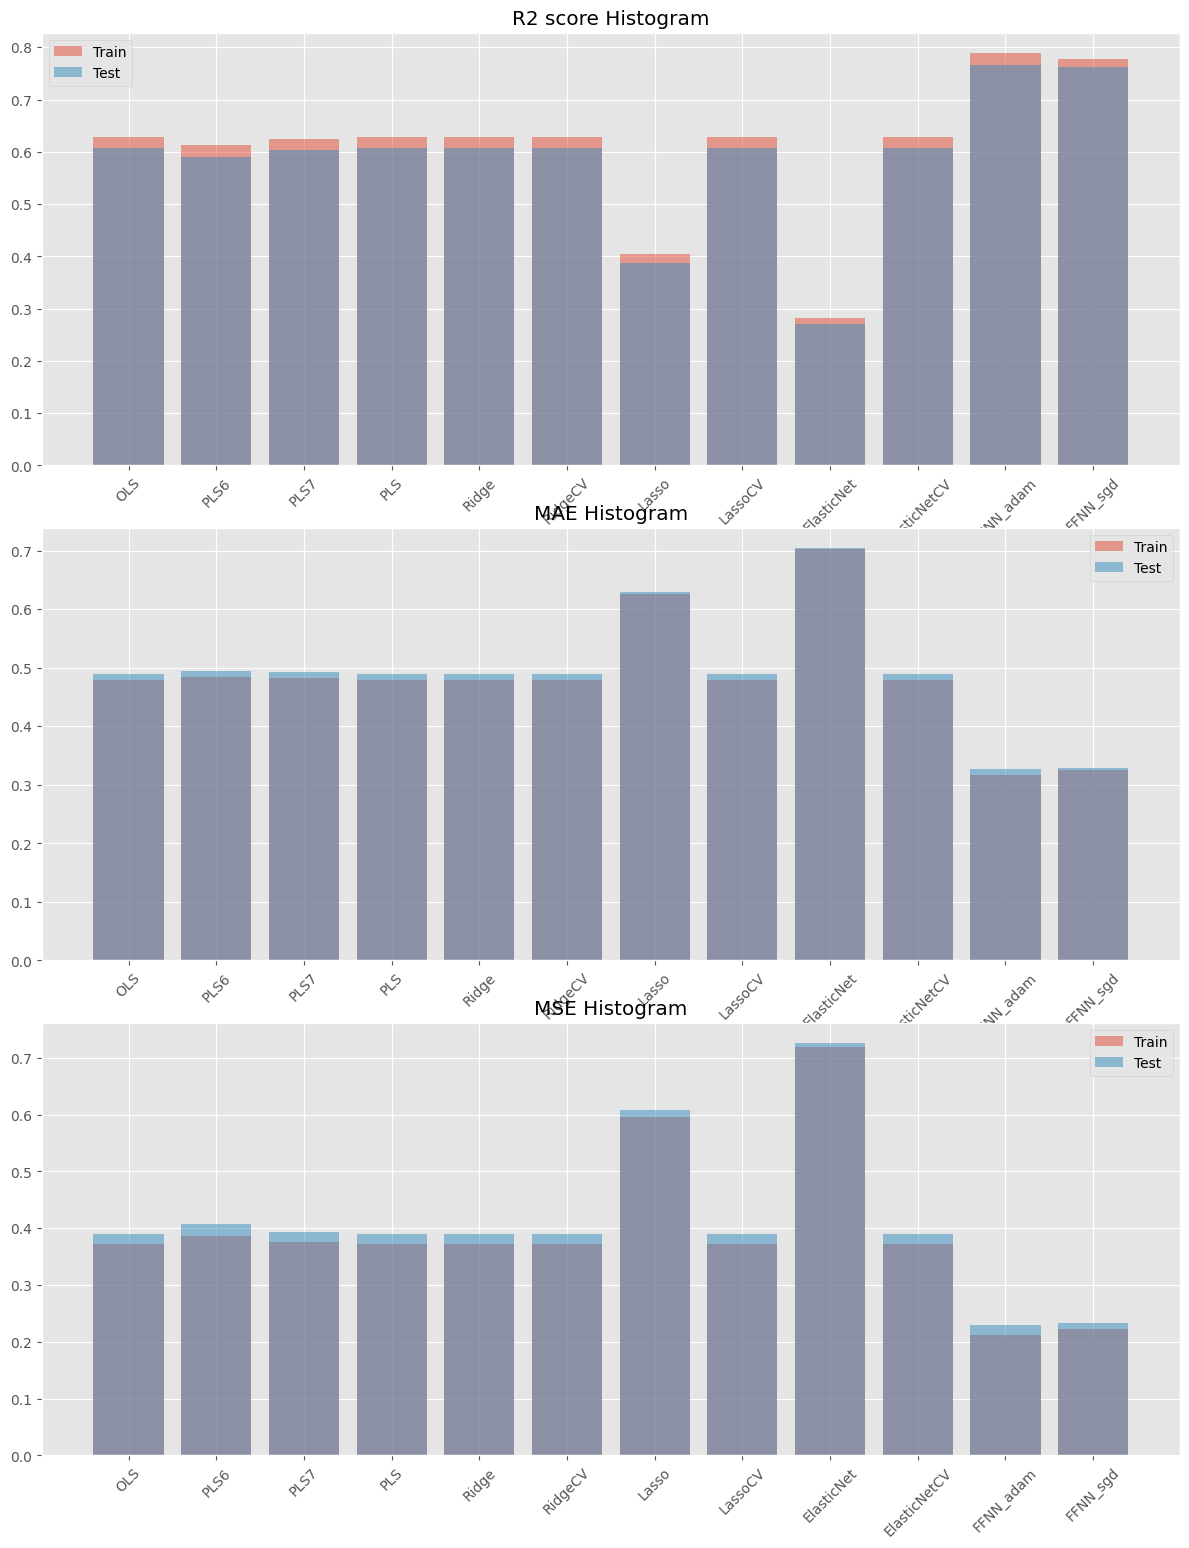

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

#R2 score
axes[0].bar(supervised_results_transpose.index, supervised_results_transpose['Train R2'], alpha=0.5, label='Train')
axes[0].bar(supervised_results_transpose.index, supervised_results_transpose['Test R2'], alpha=0.5, label='Test')
axes[0].set_title('R2 score Histogram')
axes[0].legend()

#MAE
axes[1].bar(supervised_results_transpose.index, supervised_results_transpose['Train MAE'], alpha=0.5, label='Train')
axes[1].bar(supervised_results_transpose.index, supervised_results_transpose['Test MAE'], alpha=0.5, label='Test')
axes[1].set_title('MAE Histogram')
axes[1].legend()

#MSE
axes[2].bar(supervised_results_transpose.index, supervised_results_transpose['Train MSE'], alpha=0.5, label='Train')
axes[2].bar(supervised_results_transpose.index, supervised_results_transpose['Test MSE'], alpha=0.5, label='Test')
axes[2].set_title('MSE Histogram')
axes[2].legend()

plt.tight_layout()

#Rotation of x-axis labels for better layout
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.show()

# **Findings**

From the dataframe with results and the subplots, **obvious is that FFNN produce far better metric than any other supervised model**, regardles of optimizer used. FFNN are only of all models that could produce R2 score metric above 70%, MSE bellow 30% and MAE bellow 40%.

Overall, model with Adam as optimizer produced just sligthly better results in case of R2 score, Mean squared error and Mean absolute error.

Optimization will consist two parameters,

*   epochs
*   batch_size


Epochs will take values from 50 to 500 with values [50, 100, 250,500].

Batch_size will take values from 32 to 256 with progressive step of power of 2.


### **Optimization**

Define the function that will use scikit-learn CV grid search method for finding optimal parameter values for **epochs**, and **batch_size**.

In [ ]:
def create_ffnn_model(activation='relu', loss='mean_squared_error',neurons=[8,4,2]):
    opt = Adam(lr=0.001)
    model = Sequential()
    model.add(Dense(neurons[0],
                    activation=activation,
                    input_dim=X_train.shape[1]
                   )
             )
    model.add(Dense(neurons[1],
                    activation=activation,
                   )
             )
    model.add(Dense(neurons[2],
                    activation=activation,
                   )
             )
    model.add(Dense(1,
                    activation='linear',
                    name='Output_Layer'
                   )
             )

    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=['mean_squared_error']
                 )

    return model

K folds number is 5

In [ ]:
n_cv = 5

In [ ]:
ffnn_regression_model = KerasRegressor(build_fn=create_ffnn_model, verbose=0)

search_space = dict(
      batch_size=[32,64, 128, 256],
      epochs=[50, 100, 250, 500],
      loss=['mean_squared_error']
)

ffnn_grid_search_cv = GridSearchCV(estimator=ffnn_regression_model,
                                   param_grid=search_space,
                                   scoring='neg_mean_squared_error',
                                   cv=n_cv,
                                   n_jobs=-1
                                  )

ffnn_grid_search_cv.fit(X_train, y_train)

print(f'Best score: {ffnn_grid_search_cv.best_score_:.4f}')
print('Best hyperparameters: %s' % ffnn_grid_search_cv.best_params_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best score: -0.2200
Best hyperparameters: {'batch_size': 64, 'epochs': 500, 'loss': 'mean_squared_error'}


*Calculation took 43 minutes. Be aware before running.*

**Best hyperparameters: {'batch_size': 64, 'epochs': 500, 'loss': 'mean_squared_error'}**


In [ ]:
means  = ffnn_grid_search_cv.cv_results_['mean_test_score']
stds   = ffnn_grid_search_cv.cv_results_['std_test_score']
params = ffnn_grid_search_cv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

-0.241397 (0.008539) with: {'batch_size': 32, 'epochs': 50, 'loss': 'mean_squared_error'}
-0.243338 (0.015310) with: {'batch_size': 32, 'epochs': 100, 'loss': 'mean_squared_error'}
-0.383801 (0.320566) with: {'batch_size': 32, 'epochs': 250, 'loss': 'mean_squared_error'}
-0.225844 (0.011002) with: {'batch_size': 32, 'epochs': 500, 'loss': 'mean_squared_error'}
-0.250035 (0.010605) with: {'batch_size': 64, 'epochs': 50, 'loss': 'mean_squared_error'}
-0.237127 (0.004751) with: {'batch_size': 64, 'epochs': 100, 'loss': 'mean_squared_error'}
-0.235655 (0.007178) with: {'batch_size': 64, 'epochs': 250, 'loss': 'mean_squared_error'}
-0.220013 (0.009572) with: {'batch_size': 64, 'epochs': 500, 'loss': 'mean_squared_error'}
-0.255652 (0.010131) with: {'batch_size': 128, 'epochs': 50, 'loss': 'mean_squared_error'}
-0.244744 (0.011146) with: {'batch_size': 128, 'epochs': 100, 'loss': 'mean_squared_error'}
-0.234604 (0.010831) with: {'batch_size': 128, 'epochs': 250, 'loss': 'mean_squared_error'}

###**Final model with Adam optimizer**

In [ ]:
ffnn_model_adam_final = Sequential(name='FFNN_Model')
ffnn_model_adam_final.add(Dense(8,
                     activation='relu',
                     input_dim=X_train.shape[1],
                     name='Hidden_Layer_1'
                    )
              )
ffnn_model_adam_final.add(Dense(4,
                     activation='relu',
                     name='Hidden_Layer_2'
                    )
              )
ffnn_model_adam_final.add(Dense(2,
                     activation='relu',
                     name='Hidden_Layer_3'
                    )
              )
ffnn_model_adam_final.add(Dense(1,
                     activation='linear',
                     name='Output_Layer'
                    )
              )

In [ ]:
ffnn_model_adam_final.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.R2Score(),
             tf.keras.metrics.MeanSquaredError(),
             tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
batch_size_final = 64
epochs_final = 500
ffnn_model_adam_final_ccd = ffnn_model_adam_final.fit(X_train,
                                y_train,
                                epochs=epochs_final,
                                batch_size=batch_size_final,
                                validation_data=(X_test, y_test)
                               )

Epoch 1/500
258/258 [==============================] - 1s 2ms/step - loss: 0.8462 - r2_score: 0.1570 - mean_squared_error: 0.8462 - mean_absolute_error: 0.6824 - val_loss: 0.7306 - val_r2_score: 0.2576 - val_mean_squared_error: 0.7306 - val_mean_absolute_error: 0.6233
Epoch 2/500
258/258 [==============================] - 0s 2ms/step - loss: 0.6527 - r2_score: 0.3498 - mean_squared_error: 0.6527 - mean_absolute_error: 0.5738 - val_loss: 0.5499 - val_r2_score: 0.4412 - val_mean_squared_error: 0.5499 - val_mean_absolute_error: 0.5173
Epoch 3/500
258/258 [==============================] - 0s 2ms/step - loss: 0.5126 - r2_score: 0.4894 - mean_squared_error: 0.5126 - mean_absolute_error: 0.4942 - val_loss: 0.4597 - val_r2_score: 0.5328 - val_mean_squared_error: 0.4597 - val_mean_absolute_error: 0.4702
Epoch 4/500
258/258 [==============================] - 0s 2ms/step - loss: 0.4411 - r2_score: 0.5606 - mean_squared_error: 0.4411 - mean_absolute_error: 0.4602 - val_loss: 0.4079 - val_r2_score

Optimized Adam model R2 score

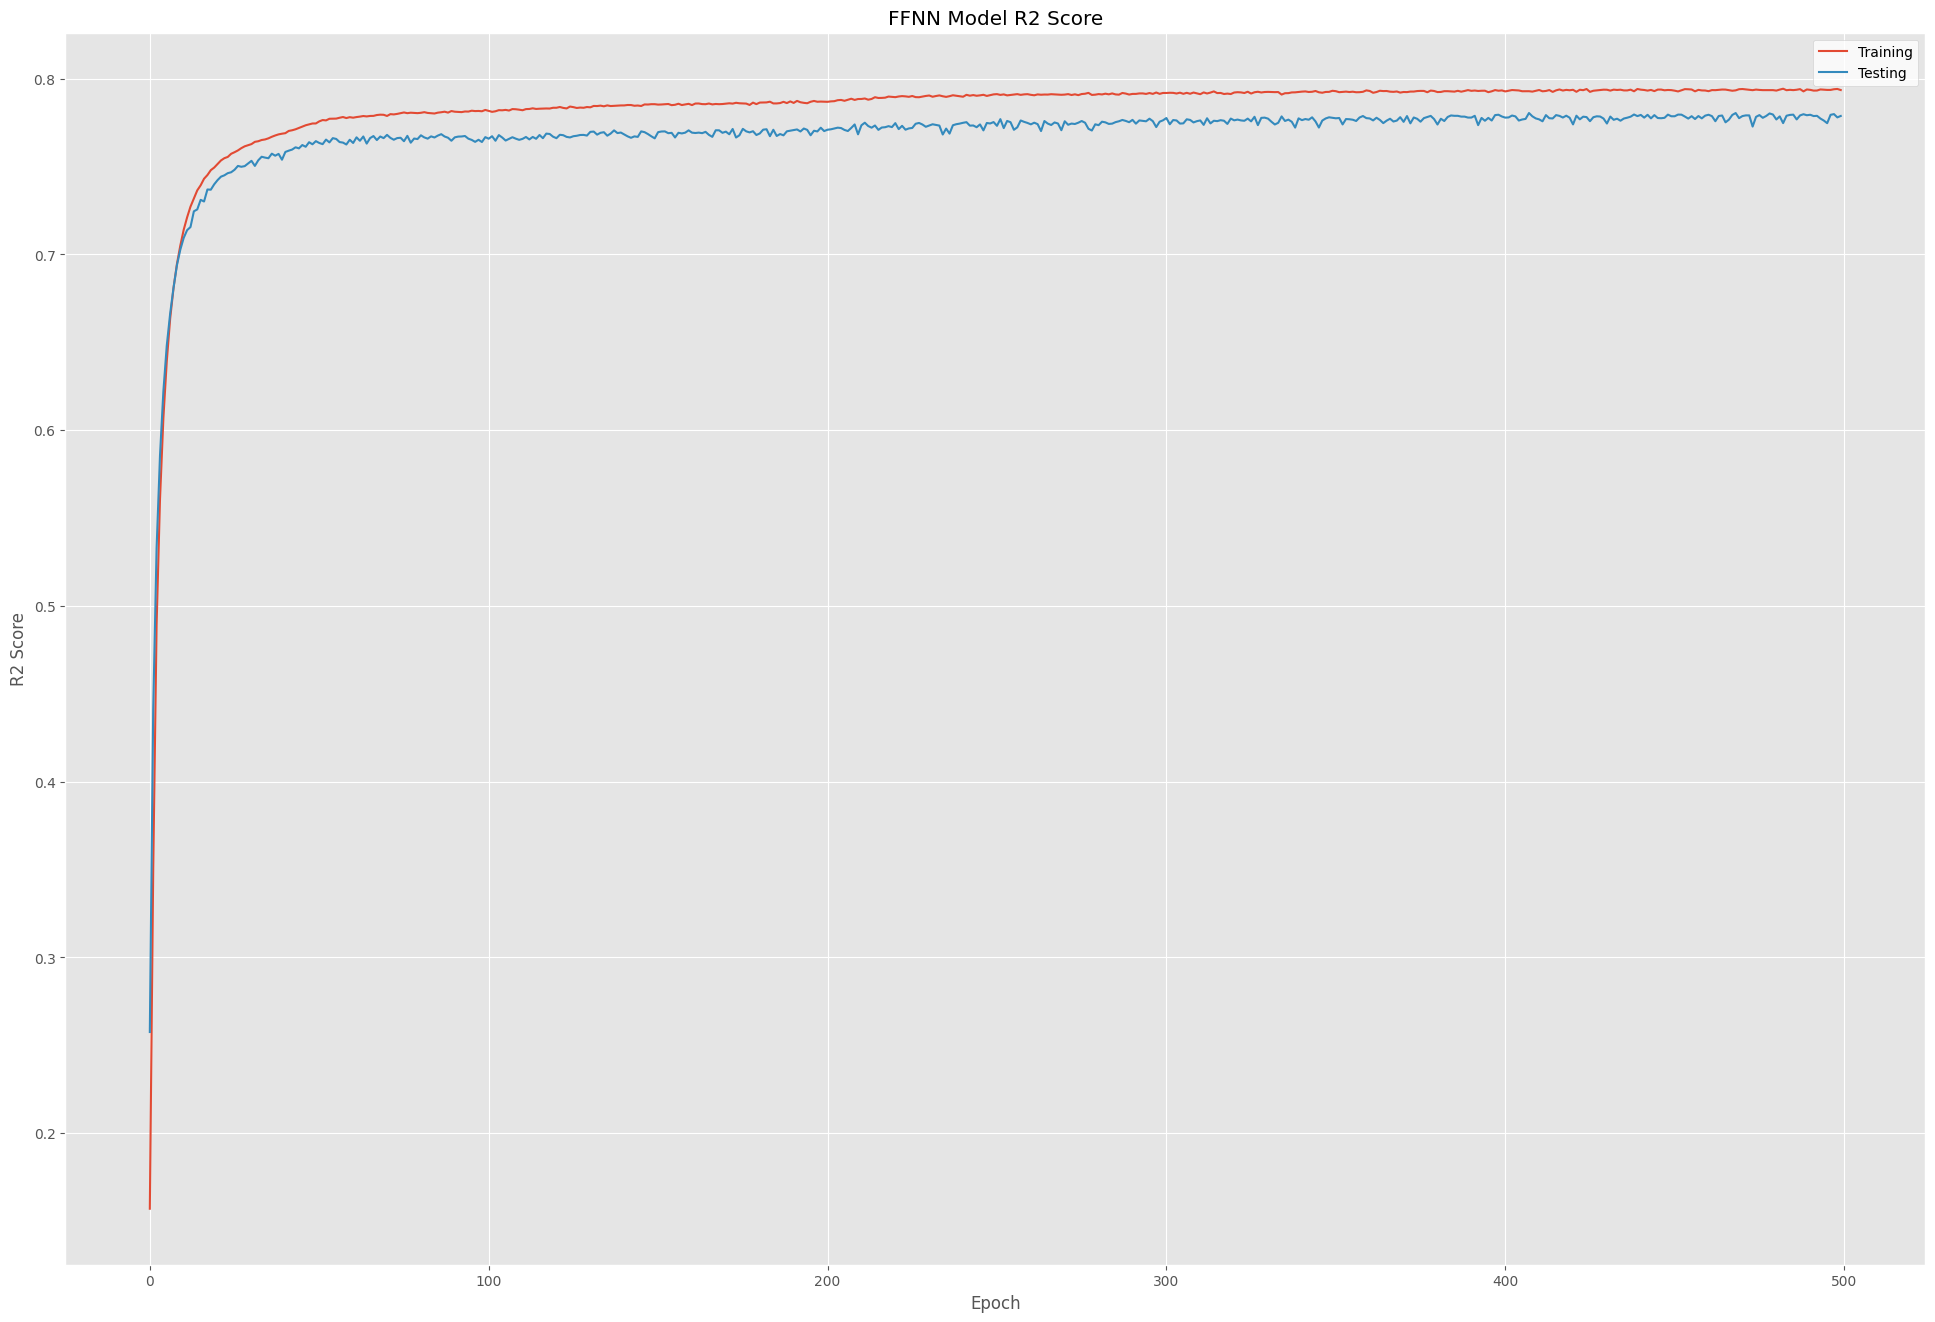

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_adam_final_ccd.history['r2_score'])
plt.plot(ffnn_model_adam_final_ccd.history['val_r2_score'])
plt.title('FFNN Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

Optimized Adam model loss function

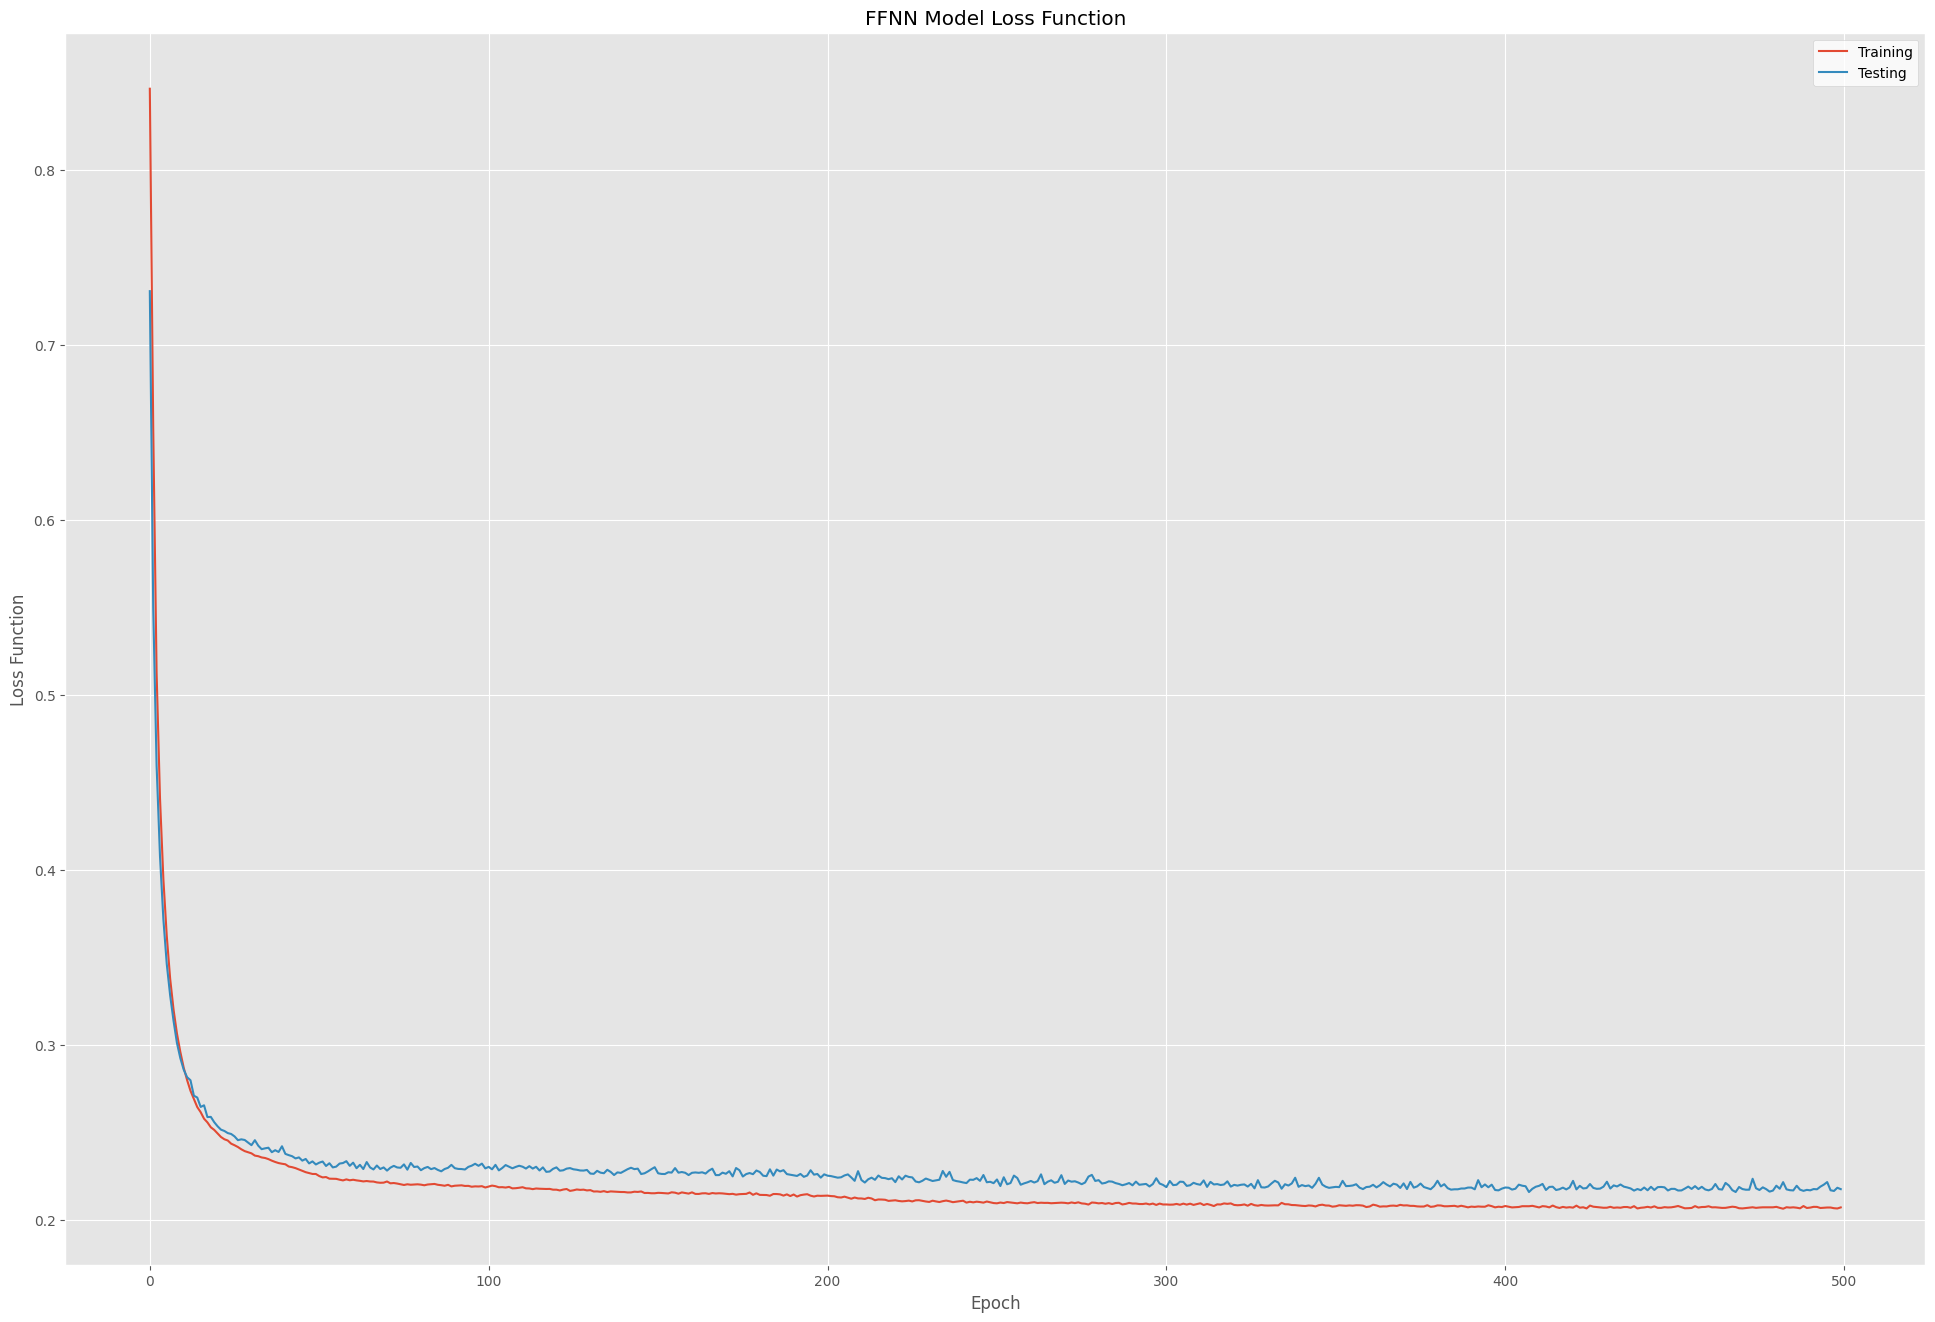

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(ffnn_model_adam_final_ccd.history['loss'])
plt.plot(ffnn_model_adam_final_ccd.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [ ]:
metrics_adam_train_final = ffnn_model_adam_final.evaluate(X_train, y_train)

516/516 [==============================] - 1s 1ms/step - loss: 0.2055 - r2_score: 0.7953 - mean_squared_error: 0.2055 - mean_absolute_error: 0.3073


In [ ]:
metrics_adam_test_final = ffnn_model_adam_final.evaluate(X_test, y_test)

129/129 [==============================] - 0s 2ms/step - loss: 0.2177 - r2_score: 0.7788 - mean_squared_error: 0.2177 - mean_absolute_error: 0.3149


In [ ]:
metrics_adam_final_optimized = [metrics_adam_train_final[1],metrics_adam_test_final[1],metrics_adam_train_final[2],metrics_adam_test_final[2],metrics_adam_train_final[3], metrics_adam_test_final[3]]
supervised_results['Optimized_adam'] = metrics_adam_final_optimized


##Preview of dataframe with all models

In [ ]:
supervised_results_transpose = supervised_results.transpose()
supervised_results

,OLS,PLS6,PLS7,PLS,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV,FFNN_adam,FFNN_sgd,Optimized_adam
Train R2,0.627655,0.613700,0.623862,0.627655,0.627655,0.627655,0.405098,0.627638,0.281270,0.627605,0.788607,0.777524,0.795271
Test R2,0.608066,0.590902,0.603757,0.608066,0.608063,0.608063,0.388042,0.608066,0.270475,0.608008,0.766167,0.762694,0.778755
Train MSE,0.372812,0.386784,0.376610,0.372812,0.372812,0.372812,0.595648,0.372829,0.719632,0.372862,0.212213,0.223339,0.205523
Test MSE,0.389943,0.407019,0.394229,0.389943,0.389945,0.389945,0.608848,0.389943,0.725818,0.390000,0.230109,0.233526,0.217722
Train MAE,0.479471,0.483717,0.481748,0.479471,0.479468,0.479468,0.625327,0.479480,0.703016,0.479464,0.316429,0.324923,0.307256
Test MAE,0.489302,0.494770,0.492617,0.489302,0.489299,0.489299,0.629463,0.489300,0.703858,0.489274,0.326092,0.329185,0.314883


###Preview percentage change of all models in comparison to optimized Adam model

In [ ]:
pct_change_df = supervised_results.divide(supervised_results['Optimized_adam'], axis=0) - 1
pct_change_df = pct_change_df.drop(columns='Optimized_adam')
pct_change_df

,OLS,PLS6,PLS7,PLS,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV,FFNN_adam,FFNN_sgd
Train R2,-0.210766,-0.228313,-0.215535,-0.210766,-0.210766,-0.210766,-0.490616,-0.210786,-0.646322,-0.210828,-0.008379,-0.022315
Test R2,-0.219182,-0.241222,-0.224714,-0.219182,-0.219185,-0.219185,-0.501714,-0.219182,-0.652683,-0.219256,-0.016164,-0.020623
Train MSE,0.813965,0.881948,0.832443,0.813965,0.813966,0.813966,1.898200,0.814045,2.501458,0.814206,0.032547,0.086684
Test MSE,0.791010,0.869442,0.810699,0.791010,0.791022,0.791022,1.796444,0.791011,2.333687,0.791275,0.056895,0.072589
Train MAE,0.560494,0.574312,0.567906,0.560494,0.560484,0.560484,1.035199,0.560525,1.288047,0.560473,0.029854,0.057500
Test MAE,0.553918,0.571283,0.564444,0.553918,0.553907,0.553907,0.999037,0.553910,1.235299,0.553828,0.035597,0.045421


###Final visual comparison with all models

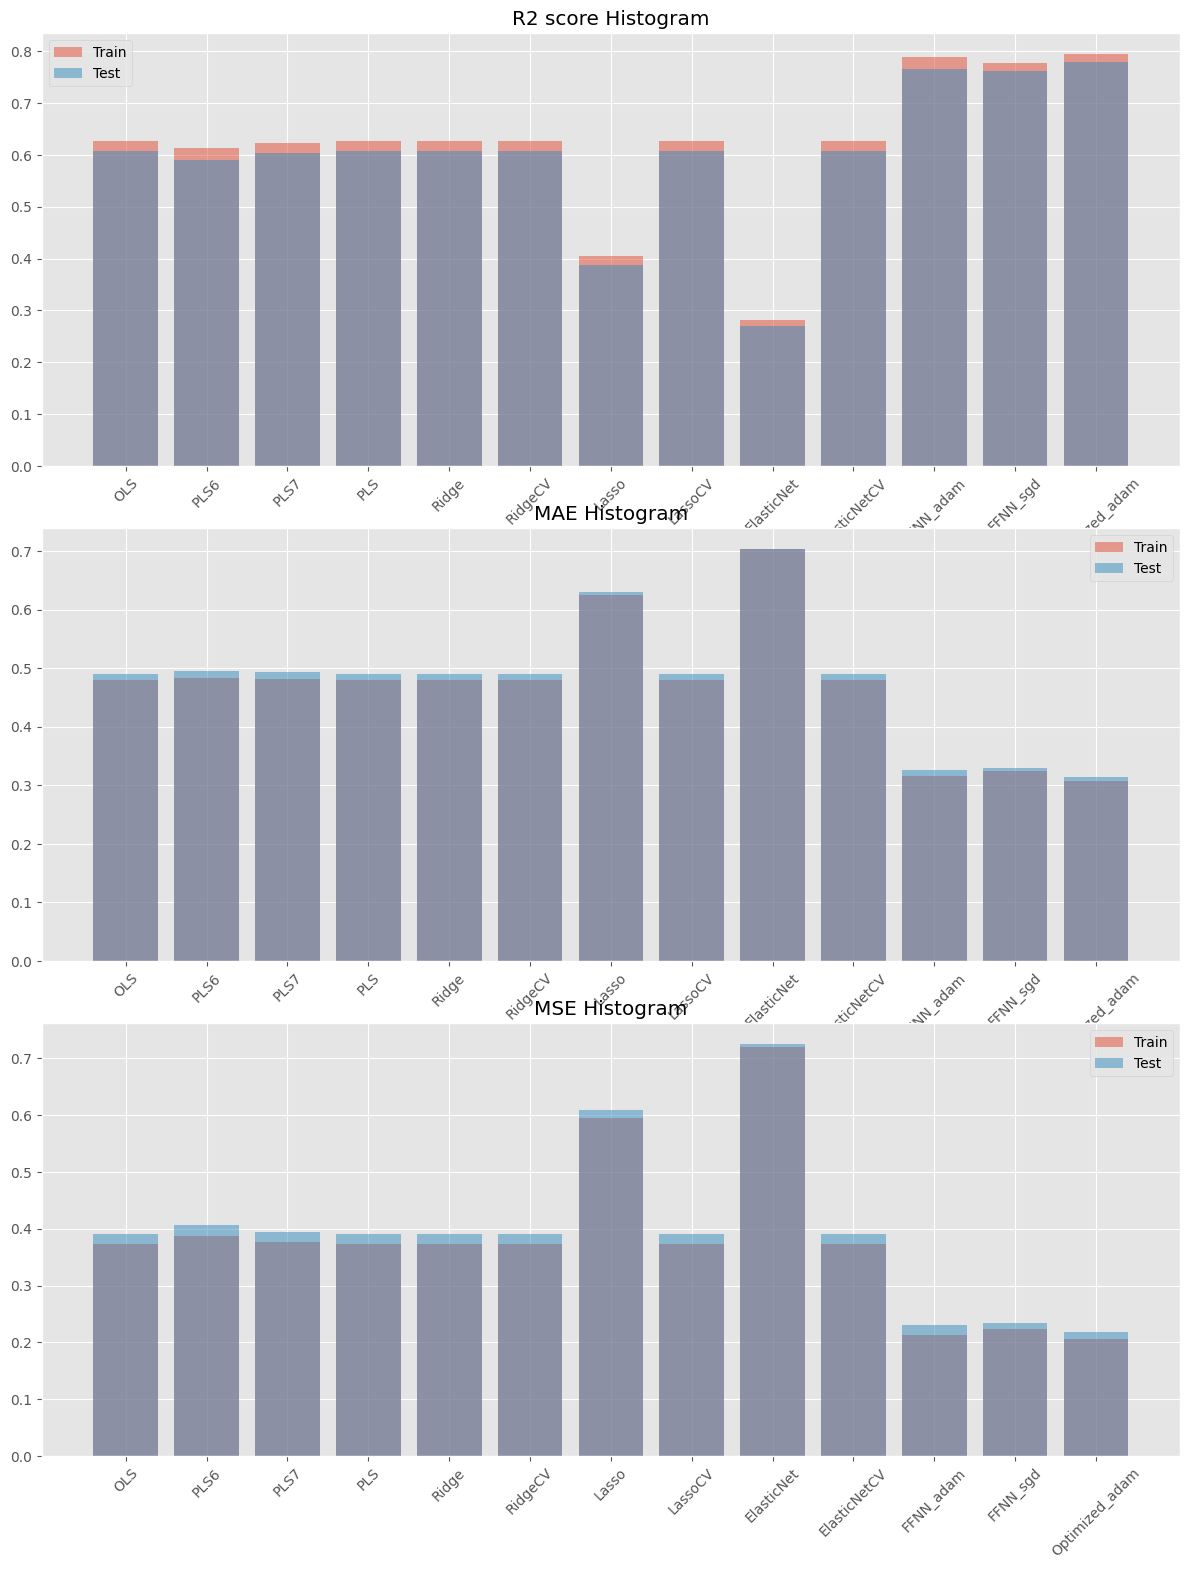

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

#R2 score
axes[0].bar(supervised_results_transpose.index, supervised_results_transpose['Train R2'], alpha=0.5, label='Train')
axes[0].bar(supervised_results_transpose.index, supervised_results_transpose['Test R2'], alpha=0.5, label='Test')
axes[0].set_title('R2 score Histogram')
axes[0].legend()

#MAE
axes[1].bar(supervised_results_transpose.index, supervised_results_transpose['Train MAE'], alpha=0.5, label='Train')
axes[1].bar(supervised_results_transpose.index, supervised_results_transpose['Test MAE'], alpha=0.5, label='Test')
axes[1].set_title('MAE Histogram')
axes[1].legend()

#MSE
axes[2].bar(supervised_results_transpose.index, supervised_results_transpose['Train MSE'], alpha=0.5, label='Train')
axes[2].bar(supervised_results_transpose.index, supervised_results_transpose['Test MSE'], alpha=0.5, label='Test')
axes[2].set_title('MSE Histogram')
axes[2].legend()

plt.tight_layout()

#Rotation of x-axis labels for better layout
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.show()

# **Final discussion**

As previously concluded, from results, obvious is that FFNN produce far better metric than any other supervised models. Between the two FFNN models, model with Adam optimizer produce better metrics. We have performed optmization of that model, in favour of its hyperparameters. After optmization, model produces 1.5% increase in R2 score, and 3.5%+ decrease in error scores on out-of-sample subset.

